In [3]:
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from factory_func import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, f1_score

In [4]:
from keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, Lambda, LSTM, TimeDistributed, Masking, Bidirectional
from keras.layers import Reshape, Flatten, Dropout, Concatenate, Activation, MaxPool2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Model, load_model, Sequential
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


In [5]:
import gzip
from gensim.models import Word2Vec

In [6]:
dev_raw = pd.read_csv(os.path.join(os.getcwd(), 'dev_sent_emo.csv'))
train_raw = pd.read_csv(os.path.join(os.getcwd(), 'train_sent_emo.csv'))
test_raw = pd.read_csv(os.path.join(os.getcwd(), 'test_sent_emo.csv'))

In [7]:
dev_raw.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049"
1,2,What?,Monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261"
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915"
3,4,Youre a genius!,Chandler,joy,positive,1,1,4,4,"00:12:32,334","00:12:33,960"
4,5,"Aww, man, now we wont be bank buddies!",Joey,sadness,negative,1,2,4,4,"00:12:34,211","00:12:37,505"


In [8]:
dev_raw.Utterance = dev_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))
train_raw.Utterance = train_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))
test_raw.Utterance = test_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))

In [9]:
x_dev = dev_raw.Utterance
y_dev = dev_raw.Emotion
x_train = train_raw.Utterance
y_train = train_raw.Emotion
x_test = test_raw.Utterance
y_test = test_raw.Emotion

### Tfidf + SVM

In [10]:
tfidf = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,3))
tfidf.fit(x_train)
x_dev_tf = tfidf.transform(x_dev)
x_train_tf = tfidf.transform(x_train)
x_test_tf = tfidf.transform(x_test)

In [11]:
svm = LinearSVC()
svm.fit(X=x_train_tf, y=y_train)
y_pred = svm.predict(x_test_tf)

Confusion matrix, without normalization
[[  54    3    2   35  201   14   36]
 [   6    4    2    6   41    4    5]
 [   2    1    2    3   35    4    3]
 [  12    2    3   97  258    9   21]
 [  57    5    7   95 1021   25   46]
 [  14    0    3   21  134   24   12]
 [  19    1    0   20  149   11   81]]


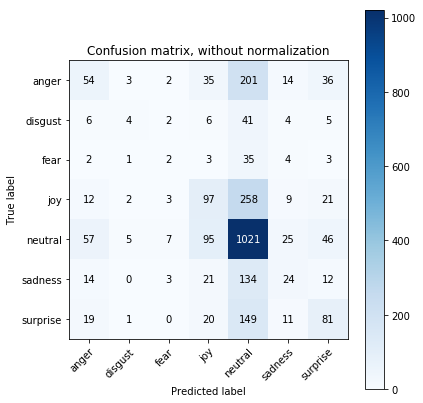

In [15]:
# confusion_matrix(y_pred=y_pred, y_true=y_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred,
                      classes=np.array(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']),
                      title='Confusion matrix, without normalization')

In [17]:
f1_score(y_pred=y_pred, y_true=y_test, average="weighted")

0.4419008692343639

### Tfidf + Neural nets

### Word2Vec + Neural nets

In [16]:
model = Word2Vec(
    docs,
    size=150,
    window=10,
    min_count=2,
    workers=10)

In [12]:
# model = Word2Vec(sentences, size=10, window=5, min_count=5, workers=1)

The first parameter passed to gensim.models.Word2Vec is an iterable of sentences. Sentences themselves are a list of words

In [20]:
model.train(docs, total_examples=len(docs), epochs=10)

(98892, 446460)

In [21]:
model.vocabulary.cum_table

array([ 249791314,  391429550,  518032306,  638312275,  744218030,
        838260155,  929951411, 1015364207, 1096914375, 1167331269,
       1231541531, 1295713810, 1356513358, 1413402723, 1460256947,
       1507068980, 1553076933, 1598872508, 1643900784, 1682215850,
       1717975816, 1752808517, 1787268007, 1820363090, 1850034532,
       1878019545, 1902156575, 1924589244, 1945439185, 1962994228,
       1979245487, 1993722433, 2004125910, 2013895873, 2023090999,
       2031920718, 2040528761, 2048913209, 2056614454, 2064161156,
       2071316766, 2078393308, 2085150565, 2091665025, 2096915207,
       2101900630, 2106886052, 2111601940, 2115762487, 2119732449,
       2123311664, 2126061648, 2128811632, 2131452334, 2133982225,
       2136399661, 2138702870, 2140402150, 2141839566, 2143140001,
       2144440436, 2145450834, 2145959037, 2146467240, 2146975444,
       2147483647], dtype=uint32)

In [35]:
w = ['oh', 'my', 'god']
w = filter(lambda x: x in model.vocab, docs.tokens)
model.wv.most_similar(positive=w, topn=6)

AttributeError: 'Series' object has no attribute 'tokens'